Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:11<00:00, 868648.37it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 55326.21it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:07<00:00, 230871.25it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2270623.21it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Epoch [10/10]: 100%|██████████| 938/938 [00:16<00:00, 55.93it/s, acc=98, loss=0.0618]   


Training Complete!
Model saved successfully!
Model loaded successfully!
Test Accuracy: 98.06%


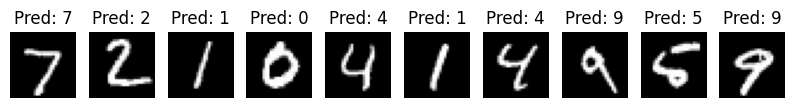

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


# ---- Custom Multi-Head Self-Attention ----
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)  # Query, Key, Value
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, N, C = x.shape  # Batch, Num Tokens, Embedding Dim
        qkv = self.qkv_proj(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = self.softmax(attn_scores)
        attn_output = torch.matmul(attn_weights, v)  # (B, num_heads, N, head_dim)
        
        attn_output = attn_output.permute(0, 2, 1, 3).reshape(B, N, C)
        return self.out_proj(attn_output)


# ---- Custom Transformer Block ----
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.norm1(x + self.attention(x))
        x = self.norm2(x + self.mlp(x))
        return x


# ---- Patch Embedding Layer ----
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(2)

    def forward(self, x):
        x = self.proj(x)
        x = self.flatten(x).transpose(1, 2)
        return x


# ---- Vision Transformer with Custom Attention ----
class ViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128, num_heads=4, num_layers=4, mlp_dim=256, num_classes=10):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        self.encoder_layers = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embedding(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embedding

        x = self.encoder_layers(x)

        x = x[:, 0, :]
        x = self.mlp_head(x)
        return x


# ---- Training Function ----
def train_vit(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

    print("Training Complete!")


# ---- Testing Function ----
def test_vit(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")


# ---- Predict and Visualize ----
def predict_and_show(model, test_loader, device, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Plot results
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    for i in range(num_samples):
        img = images[i].cpu().squeeze()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Pred: {predicted[i].item()}")
        axes[i].axis("off")
    plt.show()


# ---- Main Execution ----
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = ViT(img_size=28, patch_size=7, in_channels=1, embed_dim=128, num_heads=4, num_layers=4, mlp_dim=256, num_classes=10)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_vit(model, train_loader, criterion, optimizer, device, epochs=10)
    torch.save(model.state_dict(), "model.pth")
    print("Model saved successfully!")

    model.load_state_dict(torch.load("model.pth"))
    model.to(device)
    print("Model loaded successfully!")

    test_vit(model, test_loader, device)
    predict_and_show(model, test_loader, device)


main()
